# Auto Encoder Example.
Using an auto encoder on MNIST handwritten digits.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
    
Links:    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/


In [16]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as sio
import sys
import tarfile
import tensorflow as tf

from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
notMnistTrainingSet = pickle.load(open('notMNIST_large/D.pickle', 'rb'))


In [5]:
print(notMnistTrainingSet.shape)

(52911, 28, 28)


In [9]:
# Parameters
learning_rate = 0.01
training_epochs = 20
batch_size = 128
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 512 # 1st layer num features
n_hidden_2 = 256 # 2nd layer num features
n_hidden_3 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([n_input])),
}

In [10]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    return layer_3


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    return layer_3

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)


# Initializing the variables
init = tf.initialize_all_variables()

In [11]:
num_steps = int((notMnistTrainingSet.shape[0]-5000)/batch_size)
print(num_steps)

374


In [12]:
display_step = 100
num_steps=3001
# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)
sess = tf.InteractiveSession()
sess.run(init)
print("Initialized")
for step in range(num_steps):
# Pick an offset within the training data, which has been randomized.
# Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (notMnistTrainingSet.shape[0]-5000)
# Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    _, c = sess.run([optimizer, cost], feed_dict={X: batch_data})
    if step % display_step == 0:
        print("Epoch:", '%04d' % (step+1),"cost=", "{:.9f}".format(c))
        print("Step Count :" ,step);
        
print("Optimization Finished!")


Optimization Finished!
Initialized
Epoch: 0001 cost= 0.792436719
Step Count : 0
Epoch: 0101 cost= 0.738646030
Step Count : 100
Epoch: 0201 cost= 0.459041506
Step Count : 200
Epoch: 0301 cost= 0.388974786
Step Count : 300
Epoch: 0401 cost= 0.385824978
Step Count : 400
Epoch: 0501 cost= 0.392248511
Step Count : 500
Epoch: 0601 cost= 0.379138231
Step Count : 600
Epoch: 0701 cost= 0.375749856
Step Count : 700
Epoch: 0801 cost= 0.376846790
Step Count : 800
Epoch: 0901 cost= 0.374182642
Step Count : 900
Epoch: 1001 cost= 0.366794586
Step Count : 1000
Epoch: 1101 cost= 0.367521018
Step Count : 1100
Epoch: 1201 cost= 0.357918650
Step Count : 1200
Epoch: 1301 cost= 0.356862366
Step Count : 1300
Epoch: 1401 cost= 0.361289829
Step Count : 1400
Epoch: 1501 cost= 0.355882347
Step Count : 1500
Epoch: 1601 cost= 0.354012012
Step Count : 1600
Epoch: 1701 cost= 0.350796670
Step Count : 1700
Epoch: 1801 cost= 0.350487620
Step Count : 1800
Epoch: 1901 cost= 0.338510484
Step Count : 1900
Epoch: 2001 cost=

# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)
sess = tf.InteractiveSession()
sess.run(init)

total_batch = int(mnist.train.num_examples/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

In [63]:
num_steps=500
# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)
sess = tf.InteractiveSession()
sess.run(init)
print("Optimization Finished!")
print("Initialized")
step=207;
# Pick an offset within the training data, which has been randomized.
# Note: we could use better randomization across epochs.
offset = (step * batch_size) % (notMnistTrainingSet.shape[0]-5000-batch_size)
print("offset ", offset)
# Generate a minibatch.
batch_data = train_dataset[offset:(offset + batch_size), :]
_, c = sess.run([optimizer, cost], feed_dict={X: batch_data})
if epoch % display_step == 0:
    print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(c))
    print("Step Count :" ,step);
        
print("Optimization Finished!")


Optimization Finished!
Initialized
offset  5339
Epoch: 0001 cost= 0.781775713
Step Count : 207
Optimization Finished!


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


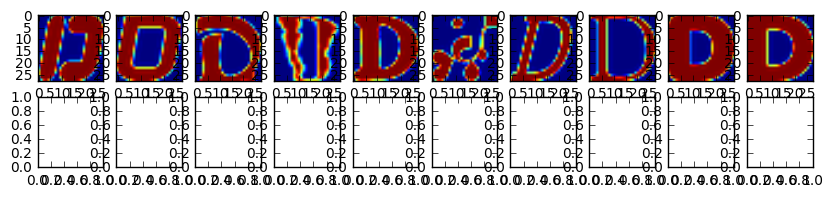

In [17]:
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(notMnistTrainingSet[i+testStartIndex], (28, 28)))
f.show()
plt.draw()

In [64]:
encode_decode = sess.run(
    y_pred, feed_dict={X:notMnistTrainingSet[testStartIndex: :testStartIndex+examples_to_show]})

In [65]:
testStartIndex=notMnistTrainingSet.shape[0]-5000;
testEndIndex=testStartIndex+examples_to_show
print(testStartIndex)
print(testEndIndex)
temp=notMnistTrainingSet[testStartIndex:testEndIndex]
print(temp.shape)

47909
47919
(10, 784)


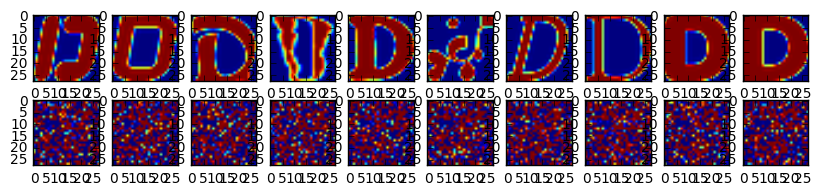

In [18]:
testStartIndex=notMnistTrainingSet.shape[0]-5000;
encode_decode = sess.run(
    y_pred, feed_dict={X:notMnistTrainingSet[testStartIndex:testStartIndex+examples_to_show]})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(notMnistTrainingSet[i+testStartIndex], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
f.show()
plt.draw()
